In [1]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import rasterio
from scipy import stats
from skimage.feature import local_binary_pattern
import pywt
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

print("Libraries installed and imported!")

Libraries installed and imported!


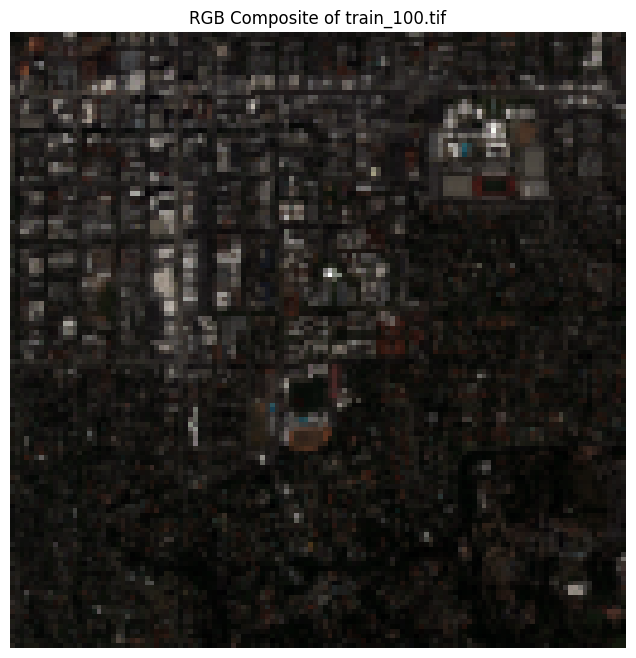

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_rgb_image(image_path):
    with rasterio.open(image_path) as src:
        red = src.read(4).astype(float)
        green = src.read(3).astype(float)
        blue = src.read(2).astype(float)

        # Handle NoData values
        red[red == src.nodata] = np.nan
        green[green == src.nodata] = np.nan
        blue[blue == src.nodata] = np.nan

    # Normalize function with safety check
    def normalize(array):
        min_val, max_val = np.nanmin(array), np.nanmax(array)
        return (array - min_val) / (max_val - min_val) if max_val > min_val else array

    rgb = np.dstack((normalize(red), normalize(green), normalize(blue)))

    plt.figure(figsize=(10, 8))
    plt.title(f"RGB Composite of {os.path.basename(image_path)}")
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

# Example usage
sample_image ="/kaggle/input/aerosol-optical-depth/train_images/train_images/train_100.tif"


plot_rgb_image(sample_image)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


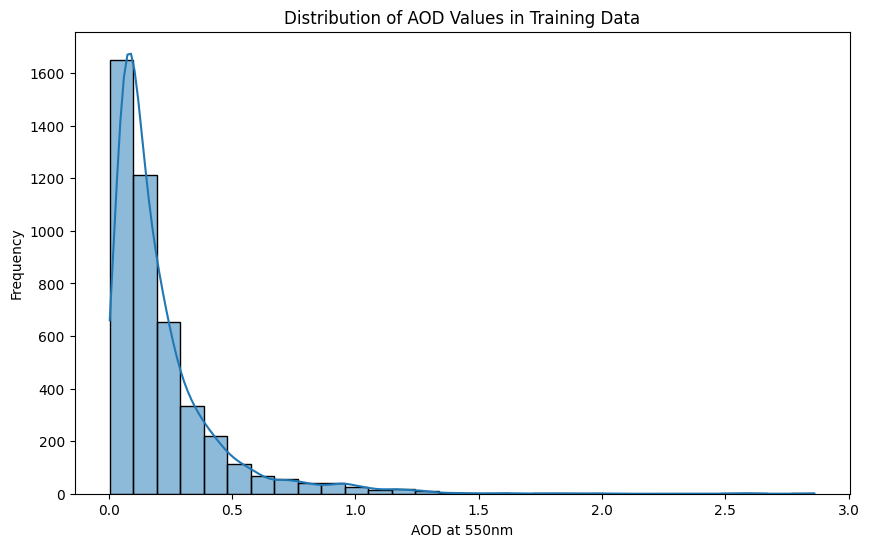

In [4]:
# [Cell 3] New: Distribution of AOD labels
def plot_aod_distribution(csv_file):
    labels = []
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            labels.append(float(row[2]))
    
    plt.figure(figsize=(10, 6))
    sns.histplot(labels, kde=True, bins=30)
    plt.title('Distribution of AOD Values in Training Data')
    plt.xlabel('AOD at 550nm')
    plt.ylabel('Frequency')
    plt.show()

plot_aod_distribution("/kaggle/input/aerosol-optical-depth/train_answer.csv")

In [5]:
def extract_features(image_path, visualize=False):
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32) / 10000 
    
    features = {}
    def calculate_ratio(band1, band2):
        return np.divide(band1, band2, where=band2!=0)

    # Ratio and statistical features
    features['ratio_band_1_8_mean_max_ratio'] = np.mean(calculate_ratio(image[0], image[7])) / np.max(calculate_ratio(image[0], image[7]))
    features['min_max_ratio_3'] = np.min(image[2]) / np.max(image[2])
    features['ratio_band_1_3_2_std'] = (np.std(calculate_ratio(image[0], image[2])) + np.std(calculate_ratio(image[0], image[1]))) / 2
    features['ratio_band_3_5_1_3_diff'] = np.mean(calculate_ratio(image[2], image[4])) - np.std(calculate_ratio(image[0], image[2]))
    features['ratio_band_2_4_1_2_diff'] = np.max(calculate_ratio(image[1], image[3])) - np.min(calculate_ratio(image[0], image[1]))
    features['ratio_band_2_3_mean_std_ratio'] = np.mean(calculate_ratio(image[1], image[2])) / np.std(calculate_ratio(image[1], image[2]))
    features['ratio_band_4_10_min_log'] = np.log1p(np.min(calculate_ratio(image[3], image[9])))
    features['ratio_band_1_8_max_mean_diff'] = np.max(calculate_ratio(image[0], image[7])) - np.mean(calculate_ratio(image[0], image[7]))
    features['ratio_band_3_5_1_3_std'] = np.std([calculate_ratio(image[2], image[4]), calculate_ratio(image[0], image[2])])
    features['band_1_2_3_4_correlation'] = np.corrcoef([image[0].flatten(), image[1].flatten(), image[2].flatten(), image[3].flatten()])[0,1]
    features['ratio_band_12_13_std'] = np.std(calculate_ratio(image[11], image[12]))
    features['band_6_13_std_ratio'] = np.std(image[5]) / np.std(image[12])
    features['ratio_band_1_7_13_max_std_ratio'] = np.max(calculate_ratio(image[0], image[6])) / np.std(calculate_ratio(image[0], image[12]))
    features['band_3_10_min_mean_diff'] = np.mean(image[2]) - np.min(image[9])
    features['ratio_band_1_9_std_min_diff'] = np.std(calculate_ratio(image[0], image[8])) - np.min(calculate_ratio(image[0], image[8]))
    features['ratio_band_3_5_mean'] = np.mean(calculate_ratio(image[2], image[4]))
    features['ratio_band_2_5_8_11_mean'] = np.mean([calculate_ratio(image[1], image[4]), calculate_ratio(image[1], image[7]), calculate_ratio(image[1], image[10])])

    # Min and pool features
    features['band_1_pool_1_min'] = np.min(image[0])
    features['band_2_pool_1_min'] = np.min(image[1])
    features['band_3_pool_1_min'] = np.min(image[2])
    features['band_7_pool_1_min'] = np.min(image[6])

    # LBP feature
    lbp = local_binary_pattern(image [0], 8, 1, method='uniform')
    features['band_1_window_3_lbp_entropy'] = stats.entropy(np.histogram(lbp, bins=256)[0])

    # Wavelet features
    coeffs = pywt.wavedec2(image[0], 'haar', level=3)
    cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    features['band_1_wavelet_haar_cD3_min'] = np.min(cD3)

    coeffs = pywt.wavedec2(image[1], 'haar', level=3)
    cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    features['band_2_wavelet_haar_cH1_max'] = np.max(cH1)
    features['band_2_wavelet_haar_cD2_max'] = np.max(cD2)
    features['band_2_wavelet_haar_cD3_min'] = np.min(cD3)

    coeffs = pywt.wavedec2(image[2], 'haar', level=3)
    cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    features['band_3_wavelet_haar_cH1_max'] = np.max(cH1)

    coeffs = pywt.wavedec2(image[3], 'haar', level=3)
    cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    features['band_4_wavelet_haar_cD1_std'] = np.std(cD1)

    coeffs = pywt.wavedec2(image[5], 'haar', level=3)
    cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    features['band_6_wavelet_haar_cH2_max'] = np.max(cH2)

    coeffs = pywt.wavedec2(image[6], 'haar', level=3)
    cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    features['band_7_wavelet_haar_cV2_max'] = np.max(cV2)

    coeffs = pywt.wavedec2(image[11], 'haar', level=3)
    cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    features['band_12_wavelet_haar_cV1_std'] = np.std(cV1)

    coeffs = pywt.wavedec2(image[12], 'haar', level=3)
    cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs
    features['band_13_wavelet_haar_cV1_min'] = np.min(cV1)
    features['band_13_wavelet_haar_cD1_std'] = np.std(cD1)
    features['band_13_wavelet_haar_cV2_std'] = np.std(cV2)
    features['band_13_wavelet_haar_cD2_std'] = np.std(cD2)
    features['band_13_wavelet_haar_cD3_std'] = np.std(cD3)

    feature_values = np.array(list(features.values()))
    feature_values = np.nan_to_num(feature_values, nan=0.0, posinf=0.0, neginf=0.0)
    
    feature_names = list(features.keys())
    # New visualization block
    if visualize:
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot band ratios
        ratio_3_5 = calculate_ratio(image[2], image[4])
        axs[0,0].imshow(ratio_3_5, cmap='viridis')
        axs[0,0].set_title('Band 3/5 Ratio')
        
        # Plot wavelet coefficients
        axs[0,1].imshow(cD3, cmap='coolwarm')
        axs[0,1].set_title('Wavelet Detail Coefficients (Level 3)')
        
        # Plot LBP texture
        axs[1,0].imshow(lbp, cmap='gray')
        axs[1,0].set_title('Local Binary Pattern (Band 1)')
        
        # Plot band correlation
        sns.heatmap(np.corrcoef([image[0].flatten(), image[1].flatten(), 
                               image[2].flatten(), image[3].flatten()]),
                    ax=axs[1,1], annot=True, cmap='coolwarm')
        axs[1,1].set_title('Band 1-4 Correlation Matrix')
        
        plt.tight_layout()
        plt.show()
    return feature_values,feature_names

/opt/conda/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


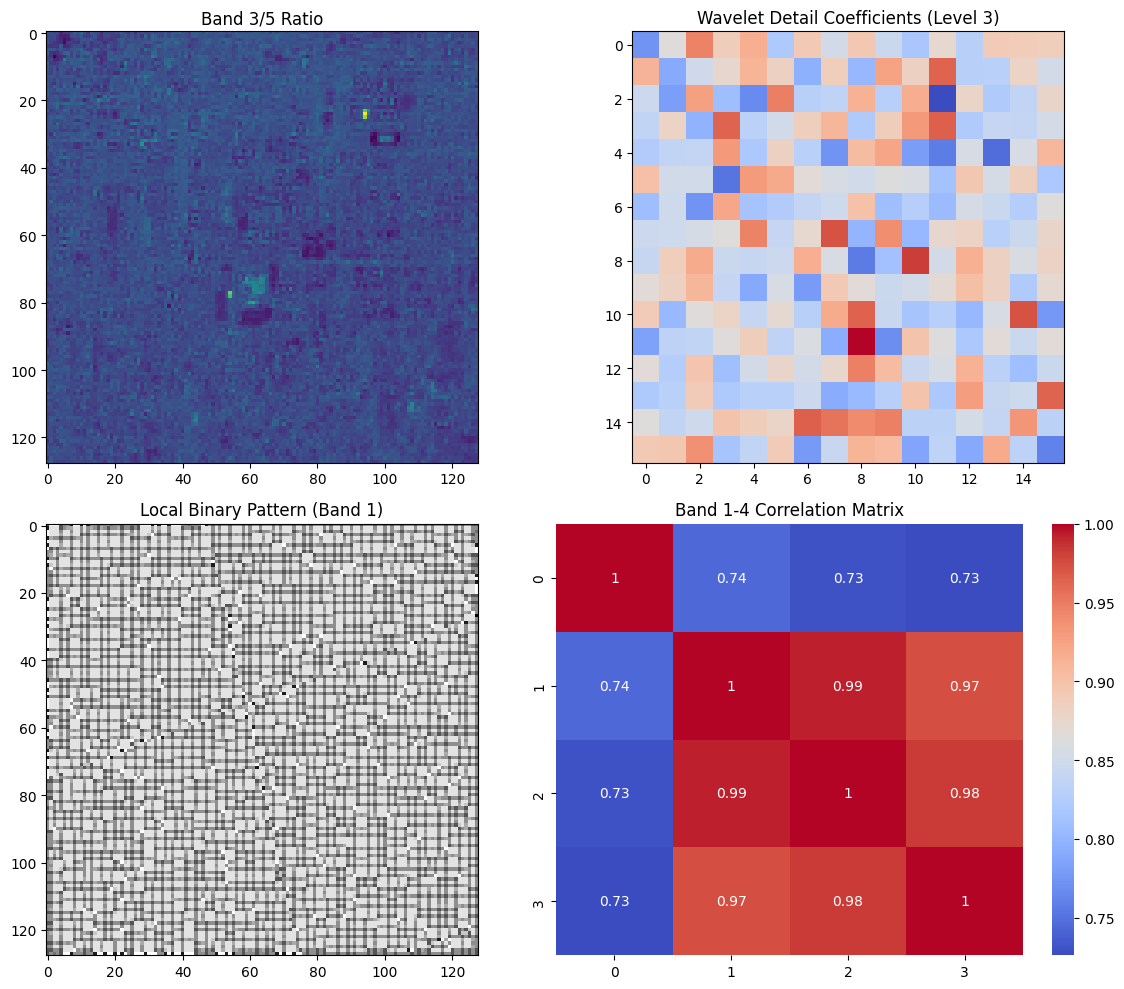

(array([ 1.99945211e-01,  1.00634925e-01,  2.25260109e-01,  6.44737959e-01,
         1.92880654e+00,  1.77994366e+01,  3.24138075e-01,  3.11184072e+00,
         2.77722299e-01,  7.43934180e-01,  2.14724422e-01,  1.07621014e+00,
         8.03630829e+00,  6.97330734e-06, -1.69403106e-02,  9.00663197e-01,
         3.44567833e+01,  1.17700001e-05,  8.17999990e-06,  6.34000025e-06,
         5.57000021e-06,  1.33766485e+00, -9.25125642e-06,  2.75900020e-05,
         3.05150024e-05, -1.47624951e-05,  2.79100004e-05,  2.15267551e-06,
         2.67424966e-05,  3.71299939e-05,  3.06650645e-06, -1.30349963e-05,
         1.23556833e-06,  5.86614760e-06,  3.69667646e-06,  6.16921170e-06]),
 ['ratio_band_1_8_mean_max_ratio',
  'min_max_ratio_3',
  'ratio_band_1_3_2_std',
  'ratio_band_3_5_1_3_diff',
  'ratio_band_2_4_1_2_diff',
  'ratio_band_2_3_mean_std_ratio',
  'ratio_band_4_10_min_log',
  'ratio_band_1_8_max_mean_diff',
  'ratio_band_3_5_1_3_std',
  'band_1_2_3_4_correlation',
  'ratio_band_12_1

In [6]:
# Visualize features for sample image
extract_features(sample_image, visualize=True)

In [7]:
import os
import csv
import numpy as np
import rasterio


def process_csv(csv_file, base_path, save_path):
    all_features = []
    all_feature_names = []
    all_labels = []

    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        for row in reader:
            file_name, _, label = row
            image_path = os.path.join(base_path, file_name)

            feature_values, feature_names = extract_features(image_path)

            all_features.append(feature_values)
            all_feature_names = feature_names  
            all_labels.append(float(label))  

    features_array = np.array(all_features)
    labels_array = np.array(all_labels)

    np.savez(save_path, features=features_array, feature_names=feature_names, labels=labels_array)
    print(f"Features and labels saved to {save_path}")


csv_file = "/kaggle/input/aerosol-optical-depth/train_answer.csv" 
base_path = "/kaggle/input/aerosol-optical-depth/train_images/train_images"  
save_path = "extracted_features_with_labels.npz" 

process_csv(csv_file, base_path, save_path)


/opt/conda/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/tmp/ipykernel_23/1280024187.py:16: RuntimeWarning: invalid value encountered in log1p
  features['ratio_band_4_10_min_log'] = np.log1p(np.min(calculate_ratio(image[3], image[9])))


Features and labels saved to extracted_features_with_labels.npz


In [8]:
import os
import numpy as np
import rasterio
import scipy

def process_folder(base_path, save_path):
    all_features = []
    all_feature_names = []
    file_names = []

    for file_name in os.listdir(base_path):
        if file_name.lower().endswith(('.tif', '.tiff')):
            image_path = os.path.join(base_path, file_name)
            feature_values, feature_names = extract_features(image_path)
            all_features.append(feature_values)
            all_feature_names = feature_names  
            file_names.append(file_name)

    features_array = np.array(all_features)

    np.savez(save_path, 
             features=features_array, 
             feature_names=all_feature_names, 
             file_names=file_names)
    
    print(f"Features saved to {save_path}")
    print(f"Number of images processed: {len(file_names)}")
    print(f"Number of features per image: {len(all_feature_names)}")

def load_features(save_path):
    loaded_data = np.load(save_path, allow_pickle=True)
    features = loaded_data['features']
    feature_names = loaded_data['feature_names']
    file_names = loaded_data['file_names']
    return features, feature_names, file_names

base_path = "/kaggle/input/aerosol-optical-depth/test_images/test_images" 
save_path = "extracted_test_features.npz" 

process_folder(base_path, save_path)


/tmp/ipykernel_23/1280024187.py:16: RuntimeWarning: invalid value encountered in log1p
  features['ratio_band_4_10_min_log'] = np.log1p(np.min(calculate_ratio(image[3], image[9])))


Features saved to extracted_test_features.npz
Number of images processed: 1489
Number of features per image: 36


In [9]:
def load_features(save_path):
    loaded_data = np.load(save_path, allow_pickle=True)
    features = loaded_data['features']
    feature_names = loaded_data['feature_names']
    file_names = loaded_data['file_names']
    return features, feature_names, file_names

# Example usage to load the saved test features
features, feature_names, file_names = load_features('extracted_test_features.npz')

print("Feature Names:", feature_names)
print("Shape of Features:", features.shape)
print("File Names:", file_names[:5])  # Display the first 5 file names

Feature Names: ['ratio_band_1_8_mean_max_ratio' 'min_max_ratio_3' 'ratio_band_1_3_2_std'
 'ratio_band_3_5_1_3_diff' 'ratio_band_2_4_1_2_diff'
 'ratio_band_2_3_mean_std_ratio' 'ratio_band_4_10_min_log'
 'ratio_band_1_8_max_mean_diff' 'ratio_band_3_5_1_3_std'
 'band_1_2_3_4_correlation' 'ratio_band_12_13_std' 'band_6_13_std_ratio'
 'ratio_band_1_7_13_max_std_ratio' 'band_3_10_min_mean_diff'
 'ratio_band_1_9_std_min_diff' 'ratio_band_3_5_mean'
 'ratio_band_2_5_8_11_mean' 'band_1_pool_1_min' 'band_2_pool_1_min'
 'band_3_pool_1_min' 'band_7_pool_1_min' 'band_1_window_3_lbp_entropy'
 'band_1_wavelet_haar_cD3_min' 'band_2_wavelet_haar_cH1_max'
 'band_2_wavelet_haar_cD2_max' 'band_2_wavelet_haar_cD3_min'
 'band_3_wavelet_haar_cH1_max' 'band_4_wavelet_haar_cD1_std'
 'band_6_wavelet_haar_cH2_max' 'band_7_wavelet_haar_cV2_max'
 'band_12_wavelet_haar_cV1_std' 'band_13_wavelet_haar_cV1_min'
 'band_13_wavelet_haar_cD1_std' 'band_13_wavelet_haar_cV2_std'
 'band_13_wavelet_haar_cD2_std' 'band_13_wavel

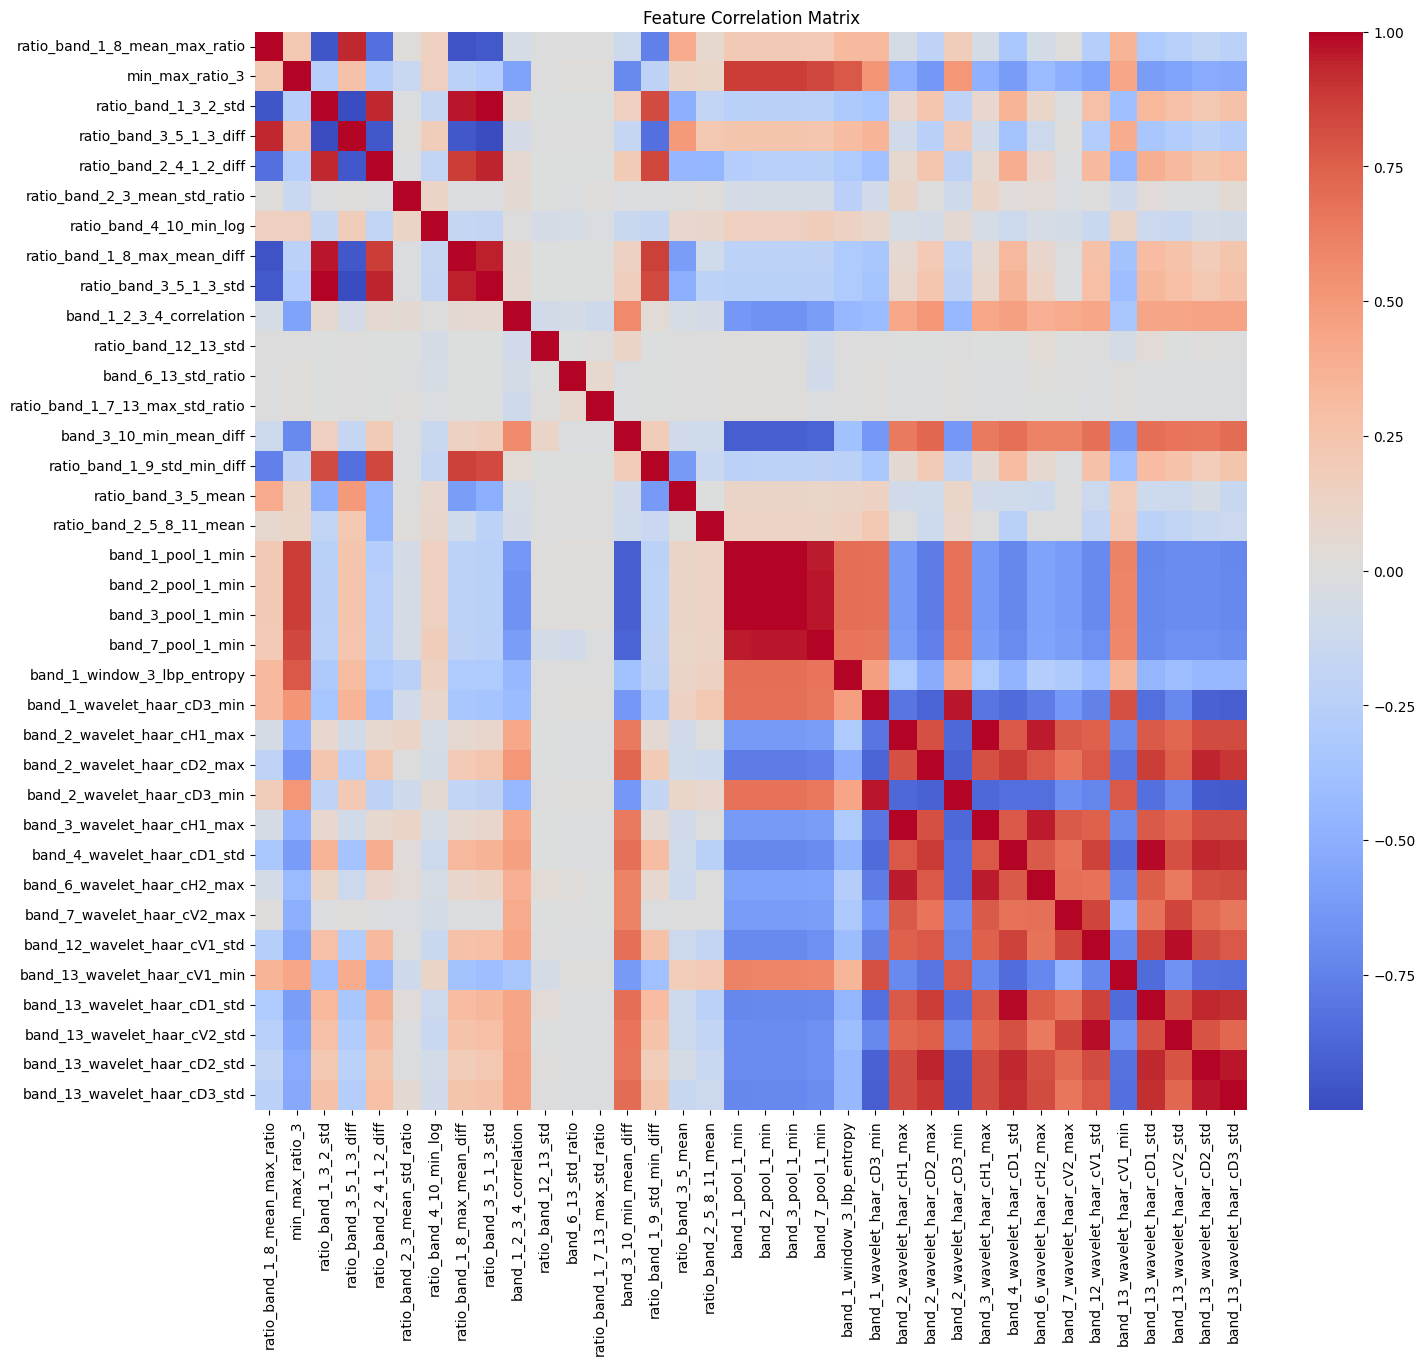

In [10]:
# [Cell 5] New: Feature correlation matrix
def plot_feature_correlation(features, feature_names):
    plt.figure(figsize=(16, 14))
    corr = np.corrcoef(features.T)
    sns.heatmap(corr, annot=False, cmap='coolwarm', 
                xticklabels=feature_names,
                yticklabels=feature_names)
    plt.title('Feature Correlation Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Load features and plot
plot_feature_correlation(features, feature_names)

# Catboost Regresssion Head

In [11]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

In [12]:
# Function to load training data
def load_features(save_path):
    loaded_data = np.load(save_path, allow_pickle=True)
    return loaded_data['features'], loaded_data['labels'], loaded_data['feature_names']

# Function to load test data
def load_test_data(test_path):
    loaded_data = np.load(test_path, allow_pickle=True)
    return loaded_data['features'], loaded_data['file_names']


def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]
def perform_cross_validation_and_predict(features, labels, test_features, params, n_folds=200):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=696)
    val_correlations = []
    test_predictions = np.zeros(len(test_features))
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    test_features_scaled = scaler.transform(test_features)
    
    for fold, (train_index, val_index) in enumerate(kf.split(features_scaled), 1):
        X_train, X_val = features_scaled[train_index], features_scaled[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, early_stopping_rounds=50, verbose=0)
        
        y_val_pred = model.predict(X_val)
        val_corr = pearson_corr(y_val, y_val_pred)
        val_correlations.append(val_corr)
        
        print(f"Fold {fold} validation correlation: {val_corr:.4f}")
        
        # Make predictions on the test set
        test_predictions += model.predict(test_features_scaled) / n_folds
    
    mean_correlation = np.mean(val_correlations)
    std_correlation = np.std(val_correlations)
    print(f"\nMean validation correlation: {mean_correlation:.4f} (±{std_correlation:.4f})")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_folds+1), val_correlations, 'bo-')
    plt.axhline(mean_correlation, color='r', linestyle='--')
    plt.xlabel('Fold Number')
    plt.ylabel('Pearson Correlation')
    plt.title(f'Cross-Validation Performance (Mean = {mean_correlation:.4f})')
    plt.grid(True)
    plt.show()
    return mean_correlation, std_correlation, test_predictions

In [13]:
# Load training features
save_path = "/kaggle/working/extracted_features_with_labels.npz"
features, labels, feature_names = load_features(save_path)

# Load test features
test_path = "/kaggle/working/extracted_test_features.npz"
test_features, file_names = load_test_data(test_path)

# Check the loaded data
print("Training Features Shape:", features.shape)
print("Test Features Shape:", test_features.shape)
print("First 5 Test File Names:", file_names[:5])

Training Features Shape: (4465, 36)
Test Features Shape: (1489, 36)
First 5 Test File Names: ['test_677.tif' 'test_100.tif' 'test_57.tif' 'test_264.tif'
 'test_1243.tif']


In [14]:
# Parameters
params = {
    'learning_rate': 0.0095416806602574589,
    'l2_leaf_reg': 0.04628983043127334, 
    'border_count': 139,
    'bagging_temperature': 3.980762682227694,
    'random_strength': 1.9451355776681154e-08, 
    'min_data_in_leaf': 1,
    'max_leaves': 178,
    'depth': 14,
    'iterations': 4343,
    'task_type': 'GPU',
    'devices': '0',
    'eval_metric': 'RMSE',
    'grow_policy': 'Lossguide',
    'verbose': 0
}

Performing cross-validation and making predictions...
Fold 1 validation correlation: 0.9933
Fold 2 validation correlation: 0.9918
Fold 3 validation correlation: 0.9867
Fold 4 validation correlation: 0.9932
Fold 5 validation correlation: 0.9893
Fold 6 validation correlation: 0.9511
Fold 7 validation correlation: 0.9815
Fold 8 validation correlation: 0.9827
Fold 9 validation correlation: 0.9853
Fold 10 validation correlation: 0.9828
Fold 11 validation correlation: 0.9771
Fold 12 validation correlation: 0.9443
Fold 13 validation correlation: 0.9935
Fold 14 validation correlation: 0.9601
Fold 15 validation correlation: 0.8077
Fold 16 validation correlation: 0.9762
Fold 17 validation correlation: 0.9519
Fold 18 validation correlation: 0.9872
Fold 19 validation correlation: 0.9913
Fold 20 validation correlation: 0.9849
Fold 21 validation correlation: 0.9532
Fold 22 validation correlation: 0.9964
Fold 23 validation correlation: 0.9897
Fold 24 validation correlation: 0.9987
Fold 25 validation 

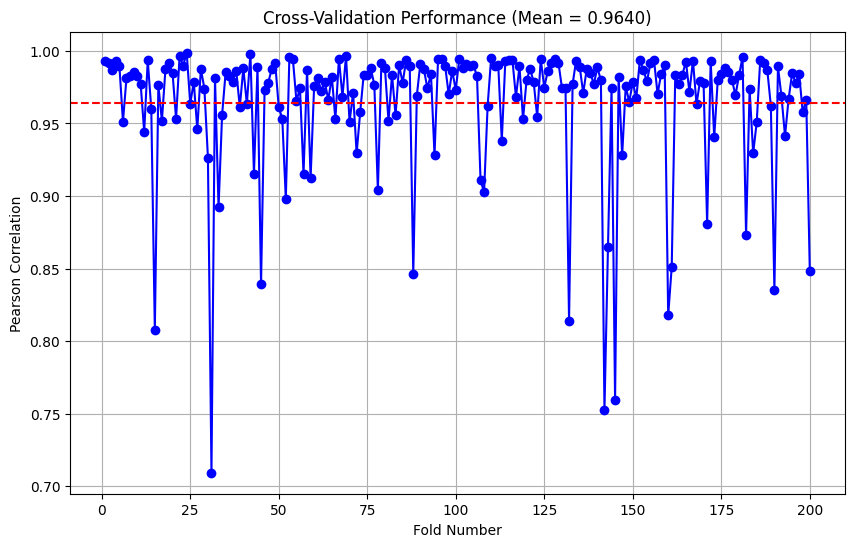

Cross-validation and prediction completed.


In [15]:
# Perform cross-validation and make predictions
print("Performing cross-validation and making predictions...")

mean_corr, std_corr, test_predictions = perform_cross_validation_and_predict(features, labels, test_features, params)


print("Cross-validation and prediction completed.")

In [16]:
# Save predictions to CSV
output_df = pd.DataFrame({'file_name': file_names, 'prediction': test_predictions})
output_df.to_csv('C_PD_9F.csv', index=False, header=False)
print("Predictions saved to 'predictions.csv'")

Predictions saved to 'predictions.csv'


In [17]:
output_df.head(10)

,file_name,prediction
0,test_677.tif,0.056817
1,test_100.tif,0.129807
2,test_57.tif,0.100628
3,test_264.tif,0.054700
4,test_1243.tif,0.046873
5,test_306.tif,0.124877
6,test_1360.tif,1.081248
7,test_1476.tif,0.253438
8,test_336.tif,0.128523
9,test_711.tif,0.338464


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


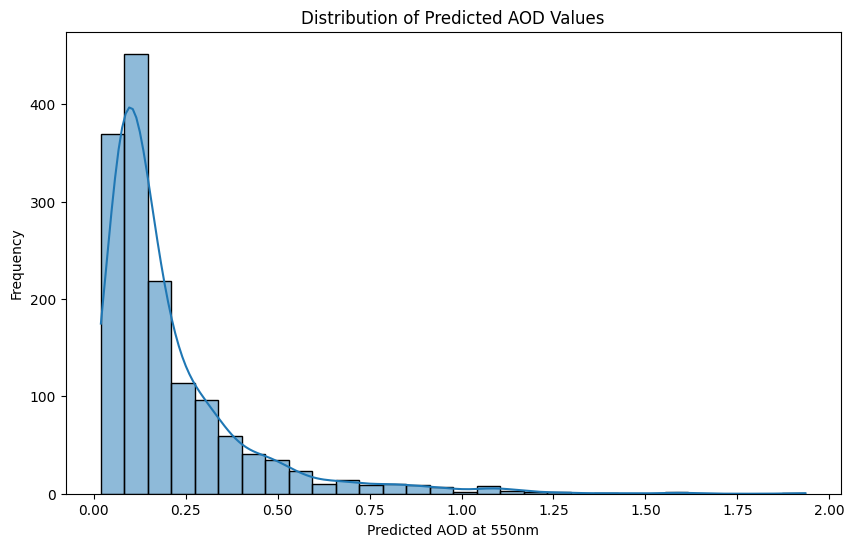

In [18]:
# [Cell 7] New: Prediction visualization
def plot_predictions_distribution(predictions):
    plt.figure(figsize=(10, 6))
    sns.histplot(predictions, kde=True, bins=30)
    plt.title('Distribution of Predicted AOD Values')
    plt.xlabel('Predicted AOD at 550nm')
    plt.ylabel('Frequency')
    plt.show()

# After generating test_predictions
plot_predictions_distribution(test_predictions)